- You are working at a wine company and are tasked with building a wine quality model. At the end you will make a recommendation to the executive team on the types of wines the company should purchase to maximize quality.

- Dataset: https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset?resource=download

- Prepare a written analysis that addresses the following:\
● What types of data cleaning or transformation did you perform?\
● What process did you take to build your predictive model?\
● What factors / features were predictive of wine quality?\
● What models and techniques did you test?\
● What were your results? Would you feel comfortable productioning this model, why or why not?\
● If you had more time, what other type of data would you want or techniques would you explore to improve your model fit?\
● Finally, what recommendation would you make to the CEO on the types of wines to target to maximize quality?


In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import Data

In [129]:
data = pd.read_csv('wines_SPA.csv')

# Exploratory Data Analysis

In [130]:
data.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [131]:
data.describe() # the statistics of numerical features

,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


In [132]:
data.info() # the columns; non-null count; dtype

# Here I find that "year", "type", "body", "acidity" have Null values
# In later steps, I consider imputing them using representative values; or delete the corresponding rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


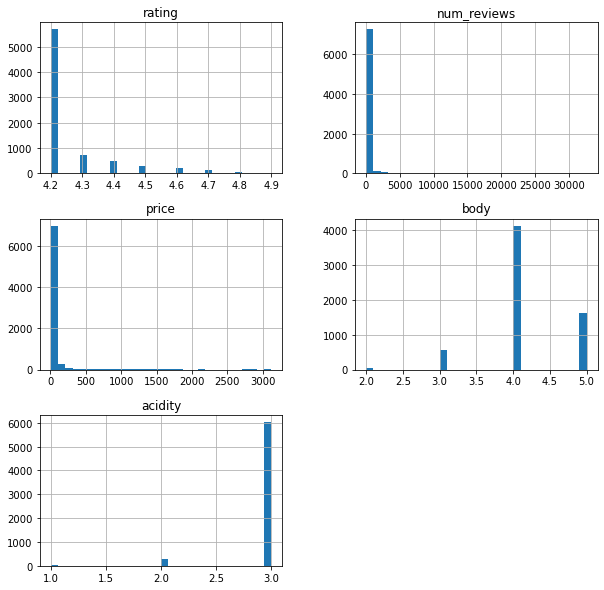

In [133]:
data.hist(bins=30, figsize=(10,10))
plt.show()

# Here I look into histograms of numerical features
# I find that
# 1) the target "rating" can have 8 values(multi-classification problems); it's highly imbalanced; 
# 2) the distribution of numerical features named "num_reviews" and "price" are skewed, I have to standardize them later using log()
# 3) the features named "body" and "acidity" are categorical features; I may use dummy to address these features 

In [134]:
data.columns

Index(['winery', 'wine', 'year', 'rating', 'num_reviews', 'country', 'region',
       'price', 'type', 'body', 'acidity'],
      dtype='object')

## year

In [135]:
print(data['year'].unique())

# Here, "year" own two wiered values including "N.V." and "nan", I delete the corresponding rows
data = data[data['year']!='N.V.']
data = data[~data['year'].isna()]

['2013' '2018' '2009' '1999' '1996' '1998' '2010' '1995' '2015' '2011'
 '2016' '1970' '1946' '1962' '2019' '2004' 'N.V.' '1931' '1979' '2005'
 '2020' '2014' '1985' '1929' '2007' '2012' '2017' '2008' nan '2006' '2000'
 '2003' '2002' '1991' '1994' '1990' '1989' '1987' '1986' '1981' '2001'
 '1968' '1964' '1982' '1974' '1983' '1955' '1980' '1972' '1953' '1958'
 '1942' '1965' '1992' '1973' '1997' '1967' '1975' '1910' '1961' '1954'
 '1988' '1969' '1951' '1928' '1976' '1949' '2021' '1959' '1922' '1978'
 '1925']


<AxesSubplot:xlabel='duration', ylabel='Count'>

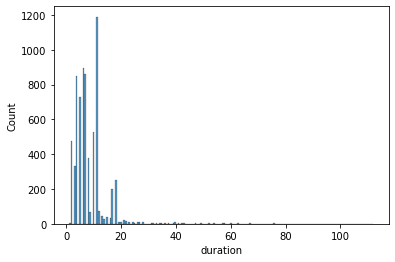

In [136]:
# I construct a new feature, calculating how long it has been since the wine has harvested 
data['duration'] = data['year'].apply(lambda x: 2022-int(x))

sns.histplot(data['duration'])
# I find that numrical feature "duration" is skewed, next I standardize it 

<AxesSubplot:xlabel='duration_', ylabel='Count'>

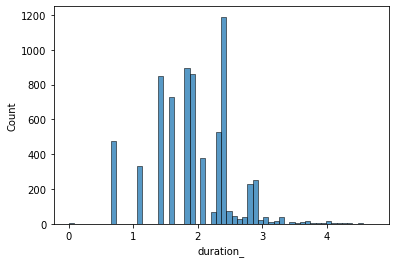

In [137]:
data['duration_'] = np.log(data['duration'])
sns.histplot(data['duration_'])

In [138]:
data[['duration_', 'rating']].corr()  # duration_ can be an informative feature 

,duration_,rating
duration_,1.000000,0.218553
rating,0.218553,1.000000


## winery 

In [139]:
print(data['winery'].nunique())

winery_groupby = data[['winery', 'num_reviews']].groupby('winery').agg({'num_reviews':'sum'}).sort_values('num_reviews', ascending=False)
winery_groupby = winery_groupby.reset_index()
print(winery_groupby.head(3))

445
          winery  num_reviews
0        Contino       178239
1  La Rioja Alta       173424
2    Matarromera       107400


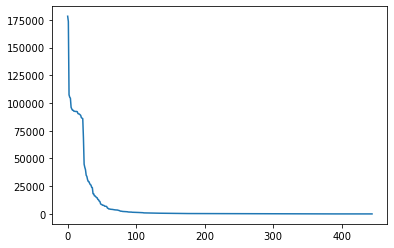

In [140]:
plt.plot(winery_groupby['num_reviews']);

# there are 445 wineries in total
# I bin them into 3 groups based on their total number of reviews, as I can see in the plot there are two changepoints   

In [141]:
high_pop_winery_lst = winery_groupby[winery_groupby['num_reviews']>=100000]['num_reviews'].tolist()
mid_pop_winery_lst = winery_groupby[(winery_groupby['num_reviews']<100000) & (winery_groupby['num_reviews']>=10000)]['num_reviews'].tolist()
data['winery_pop_type'] = data['winery'].apply(lambda x: '2' if x in high_pop_winery_lst else ('1' if x in mid_pop_winery_lst else '0'))
data.head(3)

# wineries with total number of reviews larger than 100,000 are marked as '2'
# wineries with total number of reviews smaller than 100,000 and larger than 10,000 are marked as '1'
# others are marked as '0'

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity,duration,duration_,winery_pop_type
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0,9,2.197225,0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0,4,1.386294,0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0,13,2.564949,0


## Country

In [142]:
print(data.country.nunique())

# The "country" has unique values, and thus is not informative; hence we drop the column directly 
data.drop(columns='country', inplace=True)

1


# Region

In [143]:
print(data.region.nunique())

region_groupby = data[['region', 'num_reviews']].groupby('region').agg({'num_reviews':'sum'}).sort_values('num_reviews', ascending=False)
region_groupby = region_groupby.reset_index()
print(region_groupby.head(3))

72
             region  num_reviews
0             Rioja      1124359
1  Ribera del Duero       796622
2          Priorato       226921


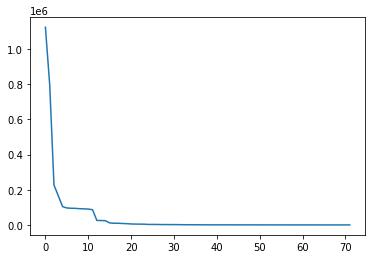

In [144]:
plt.plot(region_groupby['num_reviews']);

# there are 72 regions in total
# I bin them into 3 groups based on their total number of reviews, as I can see in the plot there are two changepoints   

In [145]:
high_pop_region_lst = region_groupby[region_groupby['num_reviews']>=100000]['region'].tolist()
mid_pop_region_lst = region_groupby[(region_groupby['num_reviews']<100000) & (region_groupby['num_reviews']>=50000)]['region'].tolist()
data['region_pop_type'] = data['region'].apply(lambda x: '2' if x in high_pop_region_lst else ('1' if x in mid_pop_region_lst else '0'))
data.head(3)

# regions with total number of reviews larger than 100,000 are marked as '2'
# wineries with total number of reviews smaller than 100,000 and larger than 50,000 are marked as '1'
# others are marked as '0'

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity,duration,duration_,winery_pop_type,region_pop_type
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0,9,2.197225,0,2
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0,4,1.386294,0,1
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0,13,2.564949,0,2


## type

In [146]:
print(data.type.nunique())
data = data[~data['type'].isna()]
data.type.info()

# there are 21 types of wineries in total
# I replace this feature using dummies in later process

21
<class 'pandas.core.series.Series'>
Int64Index: 6672 entries, 0 to 7499
Series name: type
Non-Null Count  Dtype 
--------------  ----- 
6672 non-null   object
dtypes: object(1)
memory usage: 104.2+ KB


## body

In [147]:
print(data.body.nunique())
data.body.describe()

# there are 4 types of bodies in total
# I impute the missing values using the most frequent values:4
# I replace this feature using dummies in later process
data.body.fillna(4.0, inplace=True)

4


## acidity

In [148]:
print(data.acidity.nunique())
data.acidity.describe()

# there are 3 types of acidities in total
# I impute the missing values using the most frequent values:3
# I replace this feature using dummies in later process
data.acidity.fillna(3.0, inplace=True)

3


## num_reviews

/Users/wenxinzhang/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


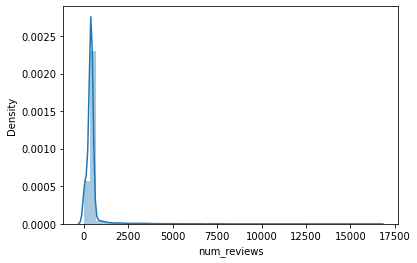

In [149]:
sns.distplot(data['num_reviews']);

# standardize "num_reviews" using log()

In [150]:
data['num_reviews_'] = np.log(data['num_reviews'])

/Users/wenxinzhang/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


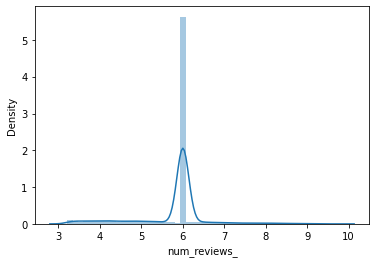

In [151]:
sns.distplot(data['num_reviews_']);

## price

/Users/wenxinzhang/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


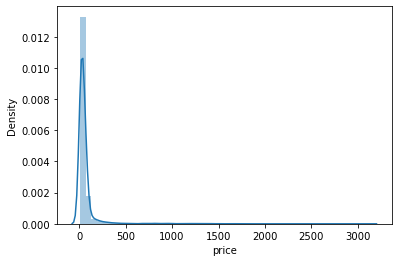

In [152]:
sns.distplot(data.price);

# standardize "price" using log()

## 

In [153]:
data['price_'] = np.log(data['price'])

/Users/wenxinzhang/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


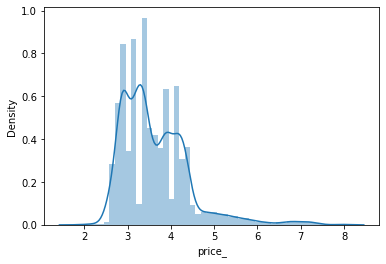

In [154]:
sns.distplot(data['price_']);

## get_dummies

In [155]:
# categorical features:
# data type transformation: float to string
data['body'] = data['body'].apply(lambda x: str(x))
data['acidity'] = data['acidity'].apply(lambda x: str(x))

In [156]:
# use dummies to replace categorical features 
data_cat = data[['type', 'body', 'acidity', 'winery_pop_type', 'region_pop_type']]
data_cat_dummy = pd.get_dummies(data_cat)
data_cat_dummy

,type_Albarino,type_Cabernet Sauvignon,type_Cava,type_Chardonnay,type_Grenache,type_Mencia,type_Monastrell,type_Montsant Red,type_Pedro Ximenez,type_Priorat Red,...,body_3.0,body_4.0,body_5.0,acidity_1.0,acidity_2.0,acidity_3.0,winery_pop_type_0,region_pop_type_0,region_pop_type_1,region_pop_type_2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
7496,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
7497,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,1,0
7498,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1


In [157]:
# concat the dummy categorical features with numerical features
data_num = data[['duration', 'num_reviews_', 'price_', 'rating']]
data_ = pd.concat([data_num, data_cat_dummy], axis=1)
data_.head()

,duration,num_reviews_,price_,rating,type_Albarino,type_Cabernet Sauvignon,type_Cava,type_Chardonnay,type_Grenache,type_Mencia,...,body_3.0,body_4.0,body_5.0,acidity_1.0,acidity_2.0,acidity_3.0,winery_pop_type_0,region_pop_type_0,region_pop_type_1,region_pop_type_2
0,9,4.060443,6.902743,4.9,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,4,3.433987,5.747799,4.9,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2,13,7.491645,5.783671,4.8,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
3,23,7.441320,6.540972,4.8,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
4,26,7.177019,6.656804,4.8,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1


## make predictions

In [158]:
# set this as a multi-classification problem
rating_lst = [round(i, 1)for i in np.arange(4.2, 5, 0.1)]
print(rating_lst)

rating_type_lst = ["A", "B", "C", "D", "E", "F", "G", "H"][::-1]
rating_type_dict = dict(zip(rating_lst, rating_type_lst))
print(rating_type_dict)

data_['rating_type'] = data_['rating'].apply(lambda x: rating_type_dict[x])
data_['rating_type']

[4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]
{4.2: 'H', 4.3: 'G', 4.4: 'F', 4.5: 'E', 4.6: 'D', 4.7: 'C', 4.8: 'B', 4.9: 'A'}


0       A
1       A
2       B
3       B
4       B
       ..
7495    H
7496    H
7497    H
7498    H
7499    H
Name: rating_type, Length: 6672, dtype: object

In [159]:
from sklearn.model_selection import train_test_split

y = data_[['rating_type']]
X = data_.drop(['rating_type', 'rating'], axis=1)

# split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8, shuffle=True, stratify=None)

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(max_depth=20, random_state=8)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_preb_probs = clf.predict_proba(X_test)
y_test = y_test.rating_type.tolist()
roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

# The multi-classification problem is unbalanced
# thus we set average = "weighted", which means: 
# calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

# The overall auc score is 0.98

/var/folders/ph/0rdmgdvx03z3s71c_pjyjg_r0000gn/T/ipykernel_3597/324351460.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.9814312706200814

In [161]:
feature_importance = pd.DataFrame({'feature': X_test.columns, 'feature_importance':clf.feature_importances_})
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
feature_importance

# we can find that the important features are ranked as follows

,feature,feature_importance
1,num_reviews_,0.450506
2,price_,0.277930
0,duration,0.145260
32,region_pop_type_0,0.028542
34,region_pop_type_2,0.010074
33,region_pop_type_1,0.007881
15,type_Rioja Red,0.007469
27,body_5.0,0.007172
14,type_Ribera Del Duero Red,0.006679
13,type_Red,0.006130
